# Importing Libraries:

In [94]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from fuzzywuzzy import fuzz
import distance
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm
from gensim.models import Word2Vec
import math
import re
from sklearn.metrics import accuracy_score, log_loss 
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
import lightgbm as ltb
import warnings
warnings.filterwarnings("ignore")

In [5]:
#from google.colab import drive
#drive.mount('/content/drive')

In [6]:
path = "train_quora.csv"
data = pd.read_csv(path)
print(data.shape)
data.head(4)

(404290, 6)


,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0


In [7]:
data_ = data

In [8]:
# Example of non-similar questions:

print('Following is the example for NON-SIMILAR questions')
print('*'*100)
print(data_['question1'].values[10])
print('*'*100)
print(data_['question2'].values[10])

Following is the example for NON-SIMILAR questions
****************************************************************************************************
Method to find separation of slits using fresnel biprism?
****************************************************************************************************
What are some of the things technicians can tell about the durability and reliability of Laptops and its components?


In [9]:
# Example of similar questions:

print('Following is the example for SIMILAR questions')
print('*'*100)
print(data_['question1'].values[11])
print('*'*100)
print(data_['question2'].values[11])

Following is the example for SIMILAR questions
****************************************************************************************************
How do I read and find my YouTube comments?
****************************************************************************************************
How can I see all my Youtube comments?


# Splitting Data:

In [10]:
x = data_.drop(['is_duplicate'],axis = 1)
y = data_['is_duplicate']

In [11]:
# Splitting the data into Train,CV and Test Sets:

x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.2,stratify = y,random_state = 0)
x_train1,x_cv,y_train1,y_cv = train_test_split(x_train,y_train,test_size = 0.2,stratify = y_train,random_state = 0)

# stratify helps in fair distribution of class labels for both train and test sets.

In [12]:
xy_train = pd.concat([x_train,y_train], axis = 1)
xy_test = pd.concat([x_test,y_test], axis = 1)

In [13]:
labels = y_train.value_counts()
labels

0    204022
1    119410
Name: is_duplicate, dtype: int64

# Distribution of class label: 0 = Not Duplicate, 1 = Duplicate


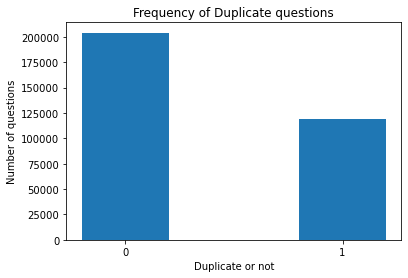

In [14]:
x_axis = [str(0),str(1)]
y_axis = [labels[0],labels[1]]

plt.bar(x_axis,y_axis,width = 0.4,)
plt.xlabel('Duplicate or not')
plt.ylabel('Number of questions')
plt.title('Frequency of Duplicate questions')
plt.show()

- We see that this is a case of slightly imbalanced dataset. (64-36)
- Number of non-duplicate questions are more than duplicate questions.

In [15]:
# Percentage of similar questions:

similar = ((labels[1])/(labels[0] + labels[1]))*100
not_similar = ((labels[0])/(labels[0] + labels[1]))*100
print('Percentage of Similar question pairs in dataset is: {}%'.format(similar))
print('Percentage of Not Similar questions in dataset is: {}%'.format(not_similar))


Percentage of Similar question pairs in dataset is: 36.91966162902867%
Percentage of Not Similar questions in dataset is: 63.08033837097133%


# Checking null values:

In [16]:
# Train set

null_value = xy_train[xy_train.isnull().any(1)]
print(null_value)

# .any(1) this returns the instance where the dataframe has null values

            id    qid1    qid2                         question1  \
363362  363362  493340  493341                               NaN   
105780  105780  174363  174364    How can I develop android app?   
201841  201841  303951  174364  How can I create an Android app?   

                                                question2  is_duplicate  
363362  My Chinese name is Haichao Yu. What English na...             0  
105780                                                NaN             0  
201841                                                NaN             0  


In [17]:
xy_train.dropna(inplace = True)

In [18]:
null_value = xy_train[xy_train.isnull().any(1)]
print(null_value)

Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []


In [19]:
# Test set

null_value = xy_test[xy_test.isnull().any(1)]
print(null_value)

Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []


In [20]:
# x_test.dropna(inplace = True)

In [21]:
# Storing two questions in seperate variable:

q1_train = xy_train.iloc[:,3].values
q2_train = xy_train.iloc[:,4].values

q1_test = xy_test.iloc[:,3].values
q2_test = xy_test.iloc[:,4].values

In [22]:
y_train = xy_train["is_duplicate"]
y_test = xy_test["is_duplicate"]

# Genreal idea about data:

In [23]:
# Here, we see which questions are repeated multiple number of times.
# We get to know about these questions through the "question id" (qid)

ques = pd.Series(xy_train['qid1'].tolist() + xy_train['qid2'].tolist())
unique_ques = len(np.unique(ques))
repeat = np.sum(ques.value_counts() > 1)
max_ques = max(ques.value_counts())
values = ques.value_counts()

idx = ques.value_counts().index.tolist()[0] # To get the qid value for question that repeats maximum number of times

maxi = xy_train.loc[(data_['qid1'] == idx)]
maxi2 = maxi[maxi.columns[[3]]]

print('Question ID and their number of occurences')
print(values[:5])


Question ID and their number of occurences
2559     132
30782     97
4044      86
17978     70
2561      70
dtype: int64


In [24]:
print('Total number of unique questions are: ',unique_ques)
print('*'*75)
print('{}% of the unique questions repeat themselves'.format(round((repeat/unique_ques)*100,2)))
print('*'*75)
print('The following question is repeated {} times'.format(max_ques))
(maxi2)

Total number of unique questions are:  450207
***************************************************************************
19.08% of the unique questions repeat themselves
***************************************************************************
The following question is repeated 132 times


,question1
113625,What are the best ways to lose weight?
213954,What are the best ways to lose weight?
379679,What are the best ways to lose weight?
402909,What are the best ways to lose weight?
81363,What are the best ways to lose weight?
377925,What are the best ways to lose weight?
115816,What are the best ways to lose weight?
288565,What are the best ways to lose weight?
360010,What are the best ways to lose weight?
268883,What are the best ways to lose weight?


# Data Cleaning:

In [25]:
lemma = WordNetLemmatizer()
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to C:\Users\PANCHAYAT  SAMITI
[nltk_data]     01\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to C:\Users\PANCHAYAT  SAMITI
[nltk_data]     01\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [26]:
# not removing stop-words yet: 
def clean(text):
    '''
    This function gets rid of all punctuation marks, special characters
    and expands the contracted words and returns words in its lemma form
    
    '''
    sent = text.lower().strip() # Done for whole sentence
    sent = re.sub('[^a-zA-Z]',' ',text) # Done for whole sentence
    sent = sent.replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will").replace("doesn't", "does not")
    sent = sent.split()
    final = [lemma.lemmatize(word) for word in sent]
    final_sent =  ' '.join(final)
    return final_sent

# The strip() method removes any leading (spaces at the beginning) and trailing (spaces at the end) characters

In [27]:
# Cleaning the train set

q1_train_clean = [] # This stores all the question1 text which has been cleaned 
for z in range(len(q1_train)):
    res = clean(str(q1_train[z]))
    q1_train_clean.append(res)
    
q2_train_clean = [] # This stores all the question2 text which has been cleaned 
for v in range(len(q2_train)):
    res2 = clean(str(q2_train[v]))
    q2_train_clean.append(res2)

In [28]:
# Cleaning the test set

q1_test_clean = [] # This stores all the question1 text which has been cleaned 
for z in range(len(q1_test)):
    res = clean(str(q1_test[z]))
    q1_test_clean.append(res)
    
q2_test_clean = [] # This stores all the question2 text which has been cleaned 
for v in range(len(q2_test)):
    res2 = clean(str(q2_test[v]))
    q2_test_clean.append(res2)

#  Feature Extraction: Train set

In [29]:
# Length of sentence
q1_train_len = [len(i.split()) for i in q1_train_clean]
q2_train_len = [len(j.split()) for j in q2_train_clean]

# Common words between two sentences
def comm(k):
    w1 = set(map(lambda word: word.lower().strip(), q1_train_clean[k].split(" "))) 
    w2 = set(map(lambda word: word.lower().strip(), q2_train_clean[k].split(" ")))    
    return len(w1&w2)
common = [comm(r) for r in range(len(q1_train_clean))] # storing the number of common words

# Word_share: (common_word_count/total number of words)

total = [a+b for a,b in zip(q1_train_len,q2_train_len)]
word_share = [round((c/d),3) for c,d in zip(common,total)] 

# cwc_min & cwc_max: (Ratio of common_word_count to min & max length of word count of Q1 and Q2)

min_len = [min(u,t) for u,t in zip(q1_train_len,q2_train_len)] # this returns length of either Q1 or Q2, whichever has minimum one.
max_len = [max(u_,t_) for u_,t_ in zip(q1_train_len,q2_train_len)] # this returns length of either Q1 or Q2, whichever has maximum one.

cwc_min = [round((e/f),3) if f!=0 else 0 for e,f in zip(common,min_len)] #if min_len =0, appending zero to avoid zero divison error
cwc_max = [round((e/f),3) for e,f in zip(common,max_len)]

# first word equal or not:

first_word = []
for g in range(len(q1_train_clean)):
    if len(q1_train_clean[g].split()) != 0 and len(q2_train_clean[g].split()) != 0: # handling the condition when length of question = 0
        s3 = q1_train_clean[g].split()[0]
        s4 = q2_train_clean[g].split()[0]
    
        if s3 == s4:
            first_word.append(1) # if first word of Q1 & Q2 is same, append 1
        else:
            first_word.append(0) # if first word of Q1 & Q2 is NOT same, append 0
    else:
        first_word.append(0)
        

# last word equal or not:
last_word = []
for g in range(len(q1_train_clean)):
    if len(q1_train_clean[g].split()) != 0 and len(q2_train_clean[g].split()) != 0:
        s3 = q1_train_clean[g].split()[-1]
        s4 = q2_train_clean[g].split()[-1]
        if s3 == s4: 
            last_word.append(1) # if last word of Q1 & Q2 is same, append 1. Else 0
        else:
            last_word.append(0)
    else:
        last_word.append(0)
        
len_diff = [abs(t1-t2) for t1,t2 in zip(q1_train_len,q2_train_len)] #this returns absolute difference between number of words in Q1 & Q2
avg_len = [(t1+t2)/2 for t1,t2 in zip(q1_train_len,q2_train_len)] #this returns average number of words in Q1 & Q2

In [30]:
# Adding these new extracted features to the dataframe

xy_train['q1_length'] = q1_train_len
xy_train['q2_length'] = q2_train_len
xy_train['common words'] = common
xy_train['word share'] = word_share
xy_train['cwc_min'] = cwc_min
xy_train['cwc_max'] = cwc_max
xy_train['first word equal'] = first_word
xy_train['last word equal'] = last_word
xy_train['difference in no.of words'] = len_diff
xy_train['avg length of words'] = avg_len

In [31]:
(xy_train.head(5))

,id,qid1,qid2,question1,question2,is_duplicate,q1_length,q2_length,common words,word share,cwc_min,cwc_max,first word equal,last word equal,difference in no.of words,avg length of words
95873,95873,21712,5041,Why do people often ask questions in Quora whi...,Why do people ask questions whose answer can b...,1,14,14,6,0.214,0.429,0.429,1,0,0,14.0
262013,262013,74232,33958,What are lucid dreams?,Is Lucid dreaming possible?,0,4,4,1,0.125,0.250,0.250,0,0,0,4.0
85654,85654,144574,144575,"Who came first, egg or the hen?",What is first a egg or an hen?,1,7,8,4,0.267,0.571,0.500,0,1,1,7.5
19837,19837,37476,37477,"What is the difference between reptiles, amphi...",What is the difference between amphibians and ...,0,9,8,8,0.471,1.000,0.889,1,0,1,8.5
105551,105551,11605,1310,What would be the best way to control anger?,How can someone control their anger?,1,9,6,2,0.133,0.333,0.222,0,1,3,7.5


#  Feature Extraction: Test set

In [32]:
# Length of sentence
q1_test_len = [len(i.split()) for i in q1_test_clean]
q2_test_len = [len(j.split()) for j in q2_test_clean]

# Common words between two sentences
def comm(k):
    w1 = set(map(lambda word: word.lower().strip(), q1_test_clean[k].split(" "))) 
    w2 = set(map(lambda word: word.lower().strip(), q2_test_clean[k].split(" ")))    
    return len(w1&w2)
common_test = [comm(r) for r in range(len(q1_test_clean))] # storing the number of common words

# Word_share: (common_word_count/total number of words)

total_test = [a+b for a,b in zip(q1_test_len,q2_test_len)]
word_share_test = [round((c/d),3) for c,d in zip(common_test,total_test)] 

# cwc_min & cwc_max: (Ratio of common_word_count to min & max length of word count of Q1 and Q2)

min_len_test = [min(u,t) for u,t in zip(q1_test_len,q2_test_len)] # this returns length of either Q1 or Q2, whichever has minimum one.
max_len_test = [max(u_,t_) for u_,t_ in zip(q1_test_len,q2_test_len)] # this returns length of either Q1 or Q2, whichever has maximum one.

cwc_min_test = [round((e/f),3) if f!=0 else 0 for e,f in zip(common_test,min_len_test)] #if min_len =0, appending zero to avoid zero divison error
cwc_max_test = [round((e/f),3) for e,f in zip(common_test,max_len_test)]

# first word equal or not:

first_word_test = []
for g in range(len(q1_test_clean)):
    if len(q1_test_clean[g].split()) != 0 and len(q2_test_clean[g].split()) != 0: # handling the condition when length of question = 0
        s3 = q1_test_clean[g].split()[0]
        s4 = q2_test_clean[g].split()[0]
    
        if s3 == s4:
            first_word_test.append(1) # if first word of Q1 & Q2 is same, append 1
        else:
            first_word_test.append(0) # if first word of Q1 & Q2 is NOT same, append 0
    else:
        first_word_test.append(0)
        

# last word equal or not:
last_word_test = []
for g in range(len(q1_test_clean)):
    if len(q1_test_clean[g].split()) != 0 and len(q2_test_clean[g].split()) != 0:
        s3 = q1_test_clean[g].split()[-1]
        s4 = q2_test_clean[g].split()[-1]
        if s3 == s4: 
            last_word_test.append(1) # if last word of Q1 & Q2 is same, append 1. Else 0
        else:
            last_word_test.append(0)
    else:
        last_word_test.append(0)
        
len_diff_test = [abs(t1-t2) for t1,t2 in zip(q1_test_len,q2_test_len)] #this returns absolute difference between number of words in Q1 & Q2
avg_len_test = [(t1+t2)/2 for t1,t2 in zip(q1_test_len,q2_test_len)] #this returns average number of words in Q1 & Q2

In [33]:
# Adding these new extracted features to the test set

xy_test['q1_length'] = q1_test_len
xy_test['q2_length'] = q2_test_len
xy_test['common words'] = common_test
xy_test['word share'] = word_share_test
xy_test['cwc_min'] = cwc_min_test
xy_test['cwc_max'] = cwc_max_test
xy_test['first word equal'] = first_word_test
xy_test['last word equal'] = last_word_test
xy_test['difference in no.of words'] = len_diff_test
xy_test['avg length of words'] = avg_len_test

In [34]:
xy_test.head(5)

,id,qid1,qid2,question1,question2,is_duplicate,q1_length,q2_length,common words,word share,cwc_min,cwc_max,first word equal,last word equal,difference in no.of words,avg length of words
35865,35865,21439,44790,Any specific ideas for mechanical final year p...,What would be some final year projects for mec...,1,8,13,5,0.238,0.625,0.385,0,0,5,10.5
83858,83858,141872,141873,Can one travel to both belarus and russia with...,Can one travel to Russia on a Belarusian visa?,1,25,9,8,0.235,0.889,0.320,1,0,16,17.0
246204,246204,359209,359210,What was the best memory of your childhood?,What was the best memory during your childhood?,1,8,8,7,0.438,0.875,0.875,1,1,0,8.0
6448,6448,12630,12631,How long do ants live?,How long does an ant typically live?,1,5,7,4,0.333,0.800,0.571,1,1,2,6.0
158190,158190,247180,247181,How do you stop cramps without medicine?,Hw can I stop period cramps without medicine?,1,7,8,4,0.267,0.571,0.500,0,1,1,7.5


# Advanced Feature Extraction (Fuzzwuzzy) : Train set

https://towardsdatascience.com/string-matching-with-fuzzywuzzy-e982c61f8a84

In [35]:
# To get longest substring ratio

def lsubstring_ratio(a, b): # abcdxyz, abcdefg ---> 4
    strs = list(distance.lcsubstrings(a, b)) # This returns the length of longest common substring
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(a), len(b)) + 1) # This gives us the LCS ratio

# partial ratio:
partial = [fuzz.partial_ratio(k.split(),l.split()) for k,l in zip(q1_train_clean,q2_train_clean)]

# token sort ratio:
token_sort = [fuzz.token_sort_ratio(k.split(),l.split()) for k,l in zip(q1_train_clean,q2_train_clean)]

# token set ratio:
token_set = [fuzz.token_set_ratio(k.split(),l.split()) for k,l in zip(q1_train_clean,q2_train_clean)]

# WRatio:
wratio = [fuzz.WRatio(k.split(),l.split()) for k,l in zip(q1_train_clean,q2_train_clean)]

# LCSubstring ratio
lcs = [lsubstring_ratio(k,l) for k,l in zip(q1_train_clean,q2_train_clean)]


In [36]:
# Adding these new advanced features to the dataframe:

xy_train["token_set_ratio"] = token_set
xy_train["token_sort_ratio"] = token_sort
xy_train["fuzz_WRatio"] = wratio
xy_train["fuzz_partial_ratio"] = partial
xy_train["longest_substr_ratio"]  = lcs

In [37]:
xy_train.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_length,q2_length,common words,word share,...,cwc_max,first word equal,last word equal,difference in no.of words,avg length of words,token_set_ratio,token_sort_ratio,fuzz_WRatio,fuzz_partial_ratio,longest_substr_ratio
95873,95873,21712,5041,Why do people often ask questions in Quora whi...,Why do people ask questions whose answer can b...,1,14,14,6,0.214,...,0.429,1,0,0,14.0,66,63,70,70,0.184211
262013,262013,74232,33958,What are lucid dreams?,Is Lucid dreaming possible?,0,4,4,1,0.125,...,0.250,0,0,0,4.0,52,52,56,61,0.476190
85654,85654,144574,144575,"Who came first, egg or the hen?",What is first a egg or an hen?,1,7,8,4,0.267,...,0.500,0,1,1,7.5,76,72,80,78,0.266667
19837,19837,37476,37477,"What is the difference between reptiles, amphi...",What is the difference between amphibians and ...,0,9,8,8,0.471,...,0.889,1,0,1,8.5,100,94,95,86,0.584906
105551,105551,11605,1310,What would be the best way to control anger?,How can someone control their anger?,1,9,6,2,0.133,...,0.222,0,1,3,7.5,54,51,56,61,0.250000


In [38]:
xy_train.to_csv('train.csv')

# Advanced Feature Extraction (Fuzzwuzzy) : Test set

In [39]:
# To get longest substring ratio

def lsubstring_ratio(a, b):
    strs = list(distance.lcsubstrings(a, b)) # This returns the length of longest common substring
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(a), len(b)) + 1) # This gives us the LCS ratio

# partial ratio:
partial_test = [fuzz.partial_ratio(k.split(),l.split()) for k,l in zip(q1_test_clean,q2_test_clean)]

# token sort ratio:
token_sort_test = [fuzz.token_sort_ratio(k.split(),l.split()) for k,l in zip(q1_test_clean,q2_test_clean)]

# token set ratio:
token_set_test = [fuzz.token_set_ratio(k.split(),l.split()) for k,l in zip(q1_test_clean,q2_test_clean)]

# WRatio:
wratio_test = [fuzz.WRatio(k.split(),l.split()) for k,l in zip(q1_test_clean,q2_test_clean)]

# LCSubstring ratio
lcs_test = [lsubstring_ratio(k,l) for k,l in zip(q1_test_clean,q2_test_clean)]


In [40]:
# Adding these new advanced features to the dataframe:

xy_test["token_set_ratio"] = token_set_test
xy_test["token_sort_ratio"] = token_sort_test
xy_test["fuzz_WRatio"] = wratio_test
xy_test["fuzz_partial_ratio"] = partial_test
xy_test["longest_substr_ratio"]  = lcs_test

In [41]:
xy_test.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_length,q2_length,common words,word share,...,cwc_max,first word equal,last word equal,difference in no.of words,avg length of words,token_set_ratio,token_sort_ratio,fuzz_WRatio,fuzz_partial_ratio,longest_substr_ratio
35865,35865,21439,44790,Any specific ideas for mechanical final year p...,What would be some final year projects for mec...,1,8,13,5,0.238,...,0.385,0,0,5,10.5,79,60,86,66,0.365385
83858,83858,141872,141873,Can one travel to both belarus and russia with...,Can one travel to Russia on a Belarusian visa?,1,25,9,8,0.235,...,0.320,1,0,16,17.0,86,54,86,85,0.391304
246204,246204,359209,359210,What was the best memory of your childhood?,What was the best memory during your childhood?,1,8,8,7,0.438,...,0.875,1,1,0,8.0,96,88,94,91,0.571429
6448,6448,12630,12631,How long do ants live?,How long does an ant typically live?,1,5,7,4,0.333,...,0.571,1,1,2,6.0,92,74,86,83,0.523810
158190,158190,247180,247181,How do you stop cramps without medicine?,Hw can I stop period cramps without medicine?,1,7,8,4,0.267,...,0.500,0,1,1,7.5,83,74,83,80,0.589744


In [42]:
xy_test.to_csv("test.csv")

In [44]:
#xy_train = pd.read_csv("/content/train.csv")
#xy_test = pd.read_csv("/content/test.csv")

# Data Visualization :

# Wordcloud

In [45]:
duplicate = xy_train[xy_train['is_duplicate'] == 1] # Storing data having class label as 1 
not_duplicate = xy_train[xy_train['is_duplicate'] == 0] # Storing data having class label as 0 

similar = np.dstack([duplicate["question1"],duplicate["question2"]]).flatten()
no_similar = np.dstack([not_duplicate["question1"], not_duplicate["question2"]]).flatten()

In [46]:
# An example of using np.dstack and flatten() operation:
gfg1 = np.array([1, 2, 3])
gfg2 = np.array([4, 5, 6])

print(np.dstack((gfg1, gfg2)))
print(np.dstack((gfg1, gfg2)).flatten())


[[[1 4]
  [2 5]
  [3 6]]]
[1 4 2 5 3 6]


In [47]:
print((similar)[:4])

['Why do people often ask questions in Quora while they can Google it themselves?'
 'Why do people ask questions whose answer can be easily found on the internet?'
 'Who came first, egg or the hen?' 'What is first a egg or an hen?']


In [48]:
print(no_similar[:4])

['What are lucid dreams?' 'Is Lucid dreaming possible?'
 'What is the difference between reptiles, amphibians, and mammals?'
 'What is the difference between amphibians and reptiles?']


In [49]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to C:\Users\PANCHAYAT
[nltk_data]     SAMITI 01\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Word Cloud for Duplicate question


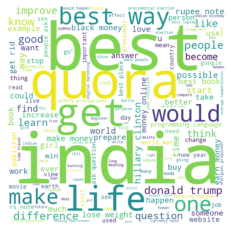

In [50]:
# Word Cloud for Duplicate question:
stop_words = set(stopwords.words("english")) # to remove the stopwords

duplicate_words = ''
for j in (similar): # This loop extracts words from sentences given to it as input
    c = (str(j).split())
    for v in c:
        b = v.lower()
        duplicate_words += "".join(b)+" "
            
wc_q = WordCloud(width = 800, height = 800,background_color ='white',stopwords = stop_words,min_font_size = 10)
wc_q.generate(duplicate_words)
print('Word Cloud for Duplicate question')
plt.imshow(wc_q, interpolation='bilinear')
plt.axis("off")
plt.show()
    

Word Cloud for Non Duplicate question


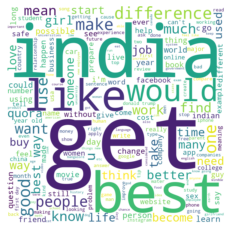

In [51]:
# Word Cloud for Non-Duplicate question:

not_duplicate_words = ''
for p in (no_similar):
    d = (str(p).split())
    for n in d:
        s = n.lower()
        not_duplicate_words += "".join(s)+" "
            
wc_q_ = WordCloud(width = 800, height = 800,background_color ='white',stopwords = stop_words,min_font_size = 10)
wc_q_.generate(not_duplicate_words)
print('Word Cloud for Non Duplicate question')
plt.imshow(wc_q_, interpolation='bilinear')
plt.axis("off")
plt.show()

# Distributions for extracted features

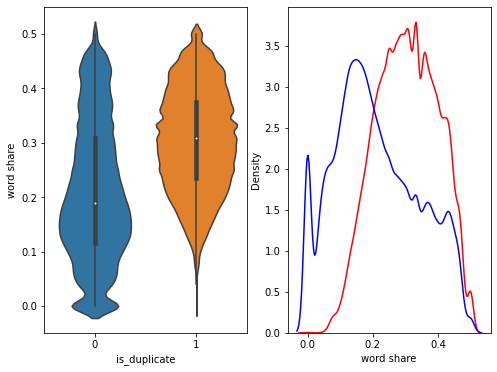

In [52]:
# Data visualization for "Word Share":

plt.figure(figsize=(8, 6))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word share', data = xy_train[0:])

plt.subplot(1,2,2)
sns.kdeplot(xy_train[xy_train['is_duplicate'] == 1.0]['word share'][0:] , label = "1", color = 'red')
sns.kdeplot(xy_train[xy_train['is_duplicate'] == 0.0]['word share'][0:] , label = "0" , color = 'blue' )
plt.show()

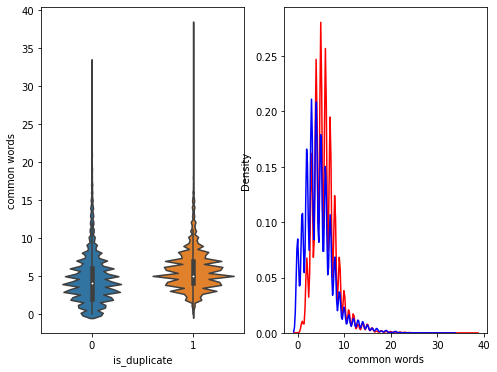

In [53]:
# Data visualization for "Common words":

plt.figure(figsize=(8, 6))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'common words', data = xy_train[0:])

plt.subplot(1,2,2)
sns.kdeplot(xy_train[xy_train['is_duplicate'] == 1.0]['common words'][0:] , label = "1", color = 'red')
sns.kdeplot(xy_train[xy_train['is_duplicate'] == 0.0]['common words'][0:] , label = "0" , color = 'blue' )
plt.show()

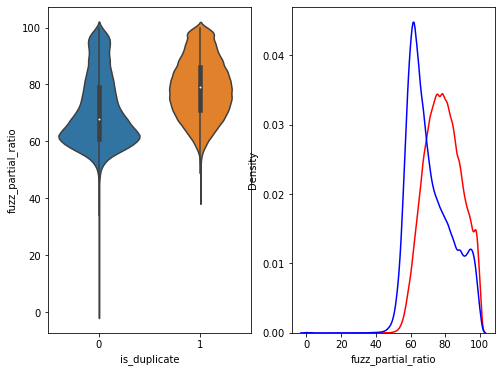

In [54]:
# Distribution of the fuzz_partial_ratio:

plt.figure(figsize=(8, 6))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'fuzz_partial_ratio', data = xy_train[0:])

plt.subplot(1,2,2)
sns.kdeplot(xy_train[xy_train['is_duplicate'] == 1.0]['fuzz_partial_ratio'][0:] , label = "1", color = 'red',)
sns.kdeplot(xy_train[xy_train['is_duplicate'] == 0.0]['fuzz_partial_ratio'][0:] , label = "0" , color = 'blue')
plt.show()

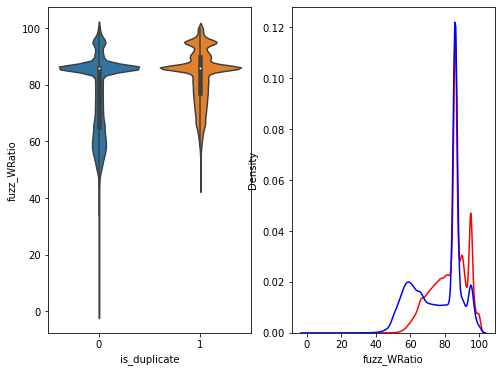

In [55]:
# Distribution of the WRatio:

plt.figure(figsize=(8, 6))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'fuzz_WRatio', data = xy_train[0:])

plt.subplot(1,2,2)
sns.kdeplot(xy_train[xy_train['is_duplicate'] == 1.0]['fuzz_WRatio'][0:] , label = "1", color = 'red',)
sns.kdeplot(xy_train[xy_train['is_duplicate'] == 0.0]['fuzz_WRatio'][0:] , label = "0" , color = 'blue')
plt.show()

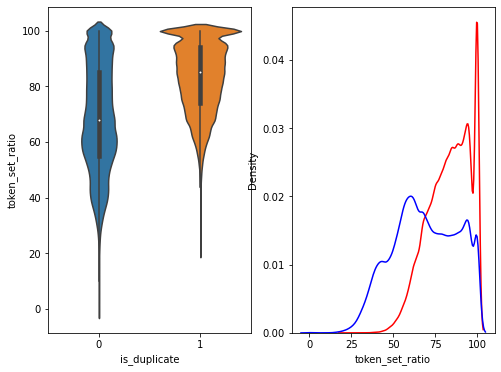

In [56]:
# Distribution of the Token Set ratio:

plt.figure(figsize=(8, 6))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'token_set_ratio', data = xy_train[0:])

plt.subplot(1,2,2)
sns.kdeplot(xy_train[xy_train['is_duplicate'] == 1.0]['token_set_ratio'][0:] , label = "1", color = 'red',)
sns.kdeplot(xy_train[xy_train['is_duplicate'] == 0.0]['token_set_ratio'][0:] , label = "0" , color = 'blue')
plt.show()

# Data Preprocessing: (Train set)

In [57]:
# Removing stop words:
all_stopwords = stopwords.words('english')

# Removing the following words from list containing stopwords
all_stopwords.remove('not')
all_stopwords.remove('but')
all_stopwords.remove('because')
all_stopwords.remove('against')
all_stopwords.remove('between')
all_stopwords.remove('up')
all_stopwords.remove('down')
all_stopwords.remove('in')
all_stopwords.remove('out')
all_stopwords.remove('once')
all_stopwords.remove('before')
all_stopwords.remove('after')
all_stopwords.remove('few')
all_stopwords.remove('more')
all_stopwords.remove('most')
all_stopwords.remove('no')
all_stopwords.remove('nor')
all_stopwords.remove('same')
all_stopwords.remove('some')

def remove_stopwords(texts):
    '''
    This function removes stopwords from the sentences
    
    '''
    sentence = texts.lower().strip()
    sentence = sentence.split()
    final1 = [word1 for word1 in sentence if not word1 in set(all_stopwords)]
    final1_ = ' '.join(final1)
    return final1_


In [58]:
xy_train

,id,qid1,qid2,question1,question2,is_duplicate,q1_length,q2_length,common words,word share,...,cwc_max,first word equal,last word equal,difference in no.of words,avg length of words,token_set_ratio,token_sort_ratio,fuzz_WRatio,fuzz_partial_ratio,longest_substr_ratio
95873,95873,21712,5041,Why do people often ask questions in Quora whi...,Why do people ask questions whose answer can b...,1,14,14,6,0.214,...,0.429,1,0,0,14.0,66,63,70,70,0.184211
262013,262013,74232,33958,What are lucid dreams?,Is Lucid dreaming possible?,0,4,4,1,0.125,...,0.250,0,0,0,4.0,52,52,56,61,0.476190
85654,85654,144574,144575,"Who came first, egg or the hen?",What is first a egg or an hen?,1,7,8,4,0.267,...,0.500,0,1,1,7.5,76,72,80,78,0.266667
19837,19837,37476,37477,"What is the difference between reptiles, amphi...",What is the difference between amphibians and ...,0,9,8,8,0.471,...,0.889,1,0,1,8.5,100,94,95,86,0.584906
105551,105551,11605,1310,What would be the best way to control anger?,How can someone control their anger?,1,9,6,2,0.133,...,0.222,0,1,3,7.5,54,51,56,61,0.250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
281943,281943,42867,66163,What is the easiest way to learn JavaScript?,What is the best way to go about learning Java...,1,8,10,6,0.333,...,0.600,1,1,2,9.0,84,84,84,76,0.272727
370194,370194,500727,500728,How and where can I buy Made Easy handwritten ...,"I have three cat steaks and four hungry boys, ...",0,14,14,3,0.107,...,0.214,0,0,0,14.0,58,55,58,60,0.071429
370367,370367,19980,10524,"Who will be USA next president, Trump or Clinton?",Who do you think will win Trump or Clinton?,1,9,9,5,0.278,...,0.556,1,1,0,9.0,75,65,74,71,0.395349
243389,243389,355817,355818,How old do I look to you? Honestly.,How old do I look?,0,8,5,5,0.385,...,0.625,1,0,3,6.5,100,68,90,97,0.944444


In [59]:
q1_train_clean1 = [] # this contains question1 without any stopwords.
for z in range(len(xy_train["question1"].values)):
    res = remove_stopwords(str(xy_train["question1"].values[z]))
    q1_train_clean1.append(res)

q2_train_clean2 = [] # this contains question2 without any stopwords.
for z in range(len(xy_train["question2"].values)):
    res2 = remove_stopwords(str(xy_train["question2"].values[z]))
    q2_train_clean2.append(res2)  

In [60]:
q1_test_clean1 = [] # this contains question1 without any stopwords.
for z in range(len(xy_test["question1"].values)):
    res = remove_stopwords(str(xy_test["question1"].values[z]))
    q1_test_clean1.append(res)

q2_test_clean2 = [] # this contains question2 without any stopwords.
for z in range(len(xy_test["question2"].values)):
    res2 = remove_stopwords(str(xy_test["question2"].values[z]))
    q2_test_clean2.append(res2)  

In [61]:
# TF-IDF Vector: Train vector

total_questions = (q1_train_clean1) + (q2_train_clean2)
tfidf = TfidfVectorizer(max_features = 1000, min_df=50)
tfidf.fit(total_questions)
q1_train_vector = tfidf.transform(q1_train_clean1).toarray()
q2_train_vector = tfidf.transform(q2_train_clean2).toarray()

# Creating a dictionary with word as a key, and the idf as a value
# This is done so that we can get TF-IDF values.

tfidf_values = dict(zip(tfidf.get_feature_names(), list(tfidf.idf_)))
print('Shape of tf-idf vector is: ',q1_train_vector.shape)

Shape of tf-idf vector is:  (323429, 1000)


C:\Users\PANCHAYAT  SAMITI 01\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [62]:
features = tfidf.get_feature_names()

# Creating my own W2V model on the Quora question pair corpus:

In [63]:
# Creating w2v model on question 1:
q1_train_list = []  
for new in (q1_train_clean1):
    q1_train_list.append(new.split())
    
w2v_q1=Word2Vec(q1_train_list,min_count=5,vector_size=100, workers=2) 
w2v_words_q1 = list(w2v_q1.wv.index_to_key) # to get the keys which are words
print("sample words ", w2v_words_q1[0:50])

# vector_size = 100---> each word will be represented by a 200 dimensional vector.
# min_count = 5---> only those words are considered which atleast ocuur (5 times) in the corpus.

sample words  ['in', 'best', 'some', 'get', 'good', 'people', 'would', 'like', 'between', 'most', 'one', 'make', 'not', 'way', 'india?', 'after', 'difference', "what's", 'know', 'learn', 'new', 'much', 'many', 'think', 'find', 'money', 'india', 'use', 'indian', 'without', 'become', 'more', 'someone', 'ever', 'but', 'quora', 'time', 'start', 'quora?', 'first', 'want', 'out', 'trump', 'life?', 'why?', 'take', 'could', 'better', 'feel', 'it?']


In [64]:
# Creating w2v model on question 2:
q2_train_list = []
for new2 in (q2_train_clean2):
    q2_train_list.append(new2.split())
    
w2v_q2 = Word2Vec(q2_train_list,min_count=5,vector_size=100, workers=2) 
w2v_words_q2 = list(w2v_q2.wv.index_to_key)

In [65]:
# Getting TF-IDF*W2V values for question 1 :

tfidf_w2v_q1 = [] # the tfidf-w2v for each question1 is stored in this list

for sent1 in tqdm(q1_train_list): # for each question1
    sent_vec1 = np.zeros(100) 
    tfidf_sum1 =0
    for word1 in sent1: # for each word in question1
        if word1 in w2v_words_q1 and word1 in features:
            vec1 = w2v_q1.wv[word1] # w2v vector for the word
            tf_idf_q1 = tfidf_values[word1]*(sent1.count(word1)/len(sent1)) # idf * tf = tfidf
            sent_vec1 += (vec1 * tf_idf_q1) # w2v * tfidf
            tfidf_sum1 += tf_idf_q1 # summation of tfidf
    if tfidf_sum1 != 0: # handling boundary condition
        sent_vec1 = sent_vec1/tfidf_sum1
    tfidf_w2v_q1.append(sent_vec1)

tfidf_w2v_q1_list = list(tfidf_w2v_q1)

100%|█████████████████████████████████████████████████████████████████████████| 323429/323429 [10:38<00:00, 506.88it/s]


In [66]:
# Getting TF-IDF*W2V values for question 2 :

tfidf_w2v_q2 = [] # the tfidf-w2v for each question 2 is stored in this list

for sent2 in tqdm(q2_train_list): # for each question2
    sent_vec2 = np.zeros(100) 
    tfidf_sum2 =0
    for word2 in sent2: # for each word in question2
        if word2 in w2v_words_q2 and word2 in features:
            vec2 = w2v_q2.wv[word2] 
            tf_idf_q2 = tfidf_values[word2]*(sent2.count(word2)/len(sent2)) 
            sent_vec2 += (vec2 * tf_idf_q2) 
            tfidf_sum2 += tf_idf_q2 
    if tfidf_sum2 != 0:
        sent_vec2 = sent_vec2/tfidf_sum2
    tfidf_w2v_q2.append(sent_vec2)

tfidf_w2v_q2_list = list(tfidf_w2v_q2)
   

100%|█████████████████████████████████████████████████████████████████████████| 323429/323429 [16:06<00:00, 334.53it/s]


In [67]:
print('The dimensions of TF_IDF_W2V is:',len(tfidf_w2v_q2[0]))

The dimensions of TF_IDF_W2V is: 100


# Data Preprocessing (Test set):

In [68]:
q1_test_list = []  
for new in (q1_test_clean1):
    q1_test_list.append(new.split())

q2_test_list = []
for new2 in (q2_test_clean2):
    q2_test_list.append(new2.split())

In [69]:
# Getting TF-IDF*W2V values for question 1 :

tfidf_w2v_q1_test = [] # the tfidf-w2v for each question1 is stored in this list

for sent1 in tqdm(q1_test_list): # for each question1
    sent_vec1 = np.zeros(100) 
    tfidf_sum1 =0
    for word1 in sent1: # for each word in question1
        if word1 in w2v_words_q1 and word1 in features:
            vec1 = w2v_q1.wv[word1] # w2v vector for the word
            tf_idf_q1 = tfidf_values[word1]*(sent1.count(word1)/len(sent1)) # idf * tf = tfidf
            sent_vec1 += (vec1 * tf_idf_q1) # w2v * tfidf
            tfidf_sum1 += tf_idf_q1 # summation of tfidf
    if tfidf_sum1 != 0: # handling boundary condition
        sent_vec1 = sent_vec1/tfidf_sum1
    tfidf_w2v_q1_test.append(sent_vec1)

tfidf_w2v_q1_list_test = list(tfidf_w2v_q1_test)

100%|███████████████████████████████████████████████████████████████████████████| 80858/80858 [04:43<00:00, 284.74it/s]


In [70]:
# Getting TF-IDF*W2V values for question 2 :

tfidf_w2v_q2_test = [] # the tfidf-w2v for each question 2 is stored in this list

for sent2 in tqdm(q2_test_list): # for each question2
    sent_vec2 = np.zeros(100) 
    tfidf_sum2 =0
    for word2 in sent2: # for each word in question2
        if word2 in w2v_words_q2 and word2 in features:
            vec2 = w2v_q2.wv[word2] 
            tf_idf_q2 = tfidf_values[word2]*(sent2.count(word2)/len(sent2)) 
            sent_vec2 += (vec2 * tf_idf_q2) 
            tfidf_sum2 += tf_idf_q2 
    if tfidf_sum2 != 0:
        sent_vec2 = sent_vec2/tfidf_sum2
    tfidf_w2v_q2_test.append(sent_vec2)

tfidf_w2v_q2_list_test = list(tfidf_w2v_q2_test)
   

100%|███████████████████████████████████████████████████████████████████████████| 80858/80858 [05:17<00:00, 254.84it/s]


# Creating final dataframe: (Train set)

In [71]:
ques1_train = pd.DataFrame(tfidf_w2v_q1_list,index = xy_train.index) # Storing the q1 vector here
ques2_train = pd.DataFrame(tfidf_w2v_q2_list,index = xy_train.index) # Storing the q2 vector here
ques1_train['id']=xy_train['id']
ques2_train['id']=xy_train['id']

In [72]:
ques1_test = pd.DataFrame(tfidf_w2v_q1_list_test,index = xy_test.index) # Storing the q1 vector here
ques2_test = pd.DataFrame(tfidf_w2v_q2_list_test,index = xy_test.index) # Storing the q2 vector here
ques1_test['id']=xy_test['id']
ques2_test['id']=xy_test['id']


In [73]:
# Dropping the features which won't be required in Modeling

X_train_ = xy_train.drop(['qid1', 'qid2', 'question1', 'question2', 'is_duplicate'], axis = 1)
X_test_ = xy_test.drop(['qid1', 'qid2', 'question1', 'question2', 'is_duplicate'], axis = 1)

In [74]:
# Merging all the dataframes:

train_vector = ques1_train.merge(ques2_train,on = 'id',how ='left')
X_train = X_train_.merge(train_vector,on = 'id',how ='left')

test_vector = ques1_test.merge(ques2_test,on = 'id',how ='left')
X_test = X_test_.merge(test_vector,on = 'id',how ='left')

In [75]:
X_train.drop(["id"],axis = 1, inplace = True)
X_test.drop(["id"],axis = 1, inplace = True)

In [76]:
print('Train data dimensions:',X_train.shape)
print('Test data dimensions:',X_test.shape)

Train data dimensions: (323429, 215)
Test data dimensions: (80858, 215)


In [77]:
print('Train data dimensions:',y_train.shape)
print('Test data dimensions:',y_test.shape)

Train data dimensions: (323429,)
Test data dimensions: (80858,)


In [78]:
X_train.to_csv('X_train.csv')
X_test.to_csv('X_test.csv')

y_train.to_csv('y_train.csv')
y_test.to_csv('y_test.csv')

In [79]:
#X_train = pd.read_csv('X_train.csv')
#X_test = pd.read_csv('X_test.csv')

#y_train = pd.read_csv('y_train.csv')
#y_test = pd.read_csv('y_test.csv')

In [80]:
X_train.head(2)

,q1_length,q2_length,common words,word share,cwc_min,cwc_max,first word equal,last word equal,difference in no.of words,avg length of words,...,90_y,91_y,92_y,93_y,94_y,95_y,96_y,97_y,98_y,99_y
0,14,14,6,0.214,0.429,0.429,1,0,0,14.0,...,0.999294,-0.460811,0.367546,-0.976681,2.58468,1.068159,0.369618,-0.909836,-0.65708,-1.247355
1,4,4,1,0.125,0.250,0.250,0,0,0,4.0,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000


In [81]:
X_test.head(2)

,q1_length,q2_length,common words,word share,cwc_min,cwc_max,first word equal,last word equal,difference in no.of words,avg length of words,...,90_y,91_y,92_y,93_y,94_y,95_y,96_y,97_y,98_y,99_y
0,8,13,5,0.238,0.625,0.385,0,0,5,10.5,...,-0.385447,2.043453,-0.806982,-0.715055,1.562307,0.437262,-0.104445,-0.536293,0.715435,-0.499209
1,25,9,8,0.235,0.889,0.320,1,0,16,17.0,...,0.677841,0.571451,0.030739,0.753049,0.504953,-0.018917,-0.302363,-0.556129,-0.893268,0.793344


In [82]:
y_train.head(2)

95873     1
262013    0
Name: is_duplicate, dtype: int64

In [83]:
y_test.head(2)

35865    1
83858    1
Name: is_duplicate, dtype: int64

In [13]:
#X_train.drop(["Unnamed: 0"	, "Unnamed: 0.1"], axis = 1, inplace = True)
#X_test.drop(["Unnamed: 0"	, "Unnamed: 0.1"], axis = 1, inplace = True)

#y_train.drop(["Unnamed: 0"], axis = 1, inplace = True)
#y_test.drop(["Unnamed: 0"], axis = 1, inplace = True)

In [108]:
from prettytable import PrettyTable
x = PrettyTable()

x.field_names = ["Model","Train-AUC", "Test-AUC"]
x.add_row(["Logistic Regression",0.79 ,0.79])
x.add_row(["XGBoost",0.8418,0.8418])
x.add_row(["LGBM",0.875,0.869])
(x)

Model,Train-AUC,Test-AUC
Logistic Regression,0.79,0.79
XGBoost,0.8418,0.8418
LGBM,0.875,0.869
